<a href="https://colab.research.google.com/github/CS23M005/DL_A1/blob/main/FFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb
import wandb
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.datasets import mnist
import random

In [3]:
(X_train1, y_train1), (X_test, y_test) = fashion_mnist.load_data()
# X_train = X_train1[0:2000]/255
# X_validation = X_train1[2001:2100]/255
# y_train = y_train1[0:2000]
# y_validation = y_train1[2001:2100]

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
kk = len(X_train1)
xt = np.split(X_train1[0:kk], [int(len(X_train1[0:kk])*0.9)])
yt = np.split(y_train1[0:kk], [int(len(y_train1[0:kk])*0.9)])
X_train = xt[0]/255
X_validation = xt[1]/255
y_train = yt[0]
y_validation = yt[1]

In [5]:
# (X_train1, y_train1), (X_test, y_test) = fashion_mnist.load_data()
# X_train = X_train1[0:40000]/255
# X_validation = X_train1[40001:50000]/255
# y_train = y_train1[0:40000]
# y_validation = y_train1[40001:50000]

In [6]:
samples_for_print = [];
unique_labels = np.unique(y_train)
u_l = np.copy(unique_labels)

while(len(unique_labels)>0):
  for i in range (0, len(y_train)):
    if(y_train[i] == unique_labels[0]):
      samples_for_print.append(X_train[i])
      unique_labels = np.setdiff1d(unique_labels,unique_labels[0])
      break


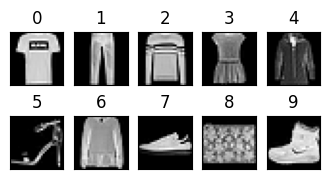

In [7]:
i = 1
rows = 2
cols = int(len(samples_for_print)/rows)
plt.figure(figsize = (4,2))
for img in samples_for_print:
    plt.subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.title(u_l[i-1])
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    i = i+1
plt.show()

In [8]:
from random import seed
import random

def init_random(n1, n2, init_mode, xav_std):
  if init_mode == "random":
    return [[np.random.normal(0,1) for i in range(n1)] for j in range(n2)]
  elif init_mode == "xavier":
    return [[np.random.normal(0,xav_std) for i in range(n1)] for j in range(n2)]

def init_nn(n_inputs, n_layers, n_neurons, n_outputs, init_mode):
  #print("in weight init")
  w = [0]*(n_layers+2)
  biases = []
  xavier_stddev = np.sqrt(2 / (n_inputs + n_outputs))
  input_layer = init_random(n_inputs, n_neurons, init_mode, xavier_stddev)
  w[1] = input_layer
  biases.append([0])
  biases.append(init_random(n_neurons, 1, init_mode, xavier_stddev)[0])
  for i in range(2,n_layers+1):
    hidden_layer = init_random(n_neurons, n_neurons, init_mode, xavier_stddev)
    w[i] = hidden_layer
    biases.append(init_random(n_neurons, 1, init_mode, xavier_stddev)[0])
  output_layer = init_random(n_neurons, n_outputs, init_mode, xavier_stddev)
  w[n_layers+1] = output_layer
  biases.append(init_random(n_outputs, 1, init_mode, xavier_stddev)[0])
  return w, biases



In [9]:
def sigmoid(x):
  x = np.clip(x, -709.78, 709.78)
  return 1. / (1.+np.exp(-x))

def sigmoid_derivative(x):
  x = np.clip(x, -709.78, 709.78)
  return sigmoid(x) * (1-sigmoid(x))

def Relu(x):
  return np.maximum(0,x)

def Relu_derivative(x):
  return 1*(x>0)

def tanh(x):
  return np.tanh(x)

def tanh_derivative(x):
  return (1 - (np.tanh(x)**2))

def softmax(x):
  x = np.clip(x, -709.78, 709.78)
  return np.exp(x) / np.sum(np.exp(x), axis=0)

def softmax_derivative(x):
  x = np.clip(x, -709.78, 709.78)
  return softmax(x) * (1-softmax(x))

def oneHotEncode(y_actual, n_outputs):
  Ydata = np.zeros(n_outputs)
  Ydata[int(y_actual)] = 1
  return Ydata



In [10]:
# def usigmoid(x):
#   x = np.array(x, dtype=np.float128)
#   return 1. / (1.+np.exp(-x))
# x = np.array([1235, -1235])
# usigmoid(x)

In [11]:

def forward_prop(w, b, sample, n_layers, activation_f):
  a = []
  h = []
  h.append(sample)
  a.append([0])
  for i in range(1, n_layers+1):
    a.append(np.matmul(np.array(w[i]),np.array(h[i-1]))+b[i])
    if activation_f == 'sigmoid':
      h.append(sigmoid(a[i]))
    elif activation_f == 'relu':
      h.append(Relu(a[i]))
    elif activation_f == 'tanh':
      h.append(tanh(a[i]))
  a.append(np.matmul(w[n_layers+1],h[n_layers])+b[n_layers+1])
  y = softmax(a[n_layers+1])
  return y, a, h



In [12]:

def backprop(y_hat, y_actual, a, h, w, b, activation_f, batch_size, loss, ud_lambda, n_outputs):

    L = len(w)-1
    gradient_a = [0]*(L+1)
    gradient_w = [0]*(L+1)
    gradient_b = [0]*(L+1)
    gradient_h = [0]*(L+1)
    y = oneHotEncode(y_actual, n_outputs)

    if loss == 'crossentropy':
      gradient_a[L] = y_hat-y
    elif loss == 'mse':
      gradient_a[L] = np.multiply(2 * (y_hat - y), np.multiply(y_hat, (1 - y_hat)))

    for k in range(L,0,-1):
      gradient_w[k] = (np.outer(gradient_a[k], h[k-1].transpose()))
      gradient_b[k] = gradient_a[k]

      if (k > 1):
        if activation_f == 'sigmoid':
          gradient_h[k-1] = np.matmul(np.array(w[k]).transpose(), np.array(gradient_a[k]))
          gradient_a[k-1]  =np.array(gradient_h[k-1]) * np.array(sigmoid_derivative(a[k-1]))

        elif activation_f == 'relu':
          gradient_h[k-1] = np.matmul(np.array(w[k]).transpose(), np.array(gradient_a[k]))
          gradient_a[k-1]  =np.array(gradient_h[k-1]) * np.array(Relu_derivative(a[k-1]))

        elif activation_f == 'tanh':
          gradient_h[k-1] = np.matmul(np.array(w[k]).transpose(), np.array(gradient_a[k]))
          gradient_a[k-1]  =np.array(gradient_h[k-1]) * np.array(tanh_derivative(a[k-1]))

    return gradient_w, gradient_b


In [13]:
def accuracy(x_data,y_data, w, b, n_layers, activation_f):
  #print("in accuracy")
  count = 0
  y_p = []
  for x,y in zip(x_data,y_data):
    sample = x.flatten()
    y_hat, a_dum, h_dum = forward_prop(w, b, sample, n_layers, activation_f)
    y_pred = np.argmax(y_hat, axis=0)
    y_p.append(y_pred)
    if y_pred == y:
      count += 1
  accuracy = count/len(y_data)
  print(count)
  return accuracy, y_p



In [14]:


def sgd(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta, init_mode, w, b, use_wandb, max_epochs):
  print("in sgd")
  L = len(w)-1
  dw = [0]*(L+1)
  db = [0]*(L+1)

  for i in range(max_epochs):
    print("epoch", i)
    for ii in range(1, n_layers+2):
      dw[ii] = np.zeros_like(w[ii])
      db[ii] = np.zeros_like(b[ii])
    num_points_seen = 0
    for x,y in zip(X_train, y_train):
      sample = x.flatten()
      y_hat, a, h = forward_prop(w, b, sample, n_layers, activation_f)
      temp_dw, temp_db = backprop(y_hat, y, a, h, w, b, activation_f, batch_size, loss, ud_lambda, n_outputs)
      #print("dw, db init happened", np.array(dw[1]).shape)
      num_points_seen = num_points_seen + 1
      for j in range(1, n_layers+2):
          dw[j] = dw[j]+ np.array(temp_dw[j])
          db[j] = db[j]+ np.array(temp_db[j])
      #print(num_points_seen)
      if (num_points_seen % batch_size) == 0:
        #print("update rule start: ", num_points_seen)
        for j in range(1, n_layers+2):
          w[j] = (w[j]-eta*dw[j])
          b[j] = b[j]-eta*db[j]
        #print("update rule end: ", num_points_seen)
        for ii in range(1, n_layers+2):
          dw[ii] = np.zeros_like(w[ii])
          db[ii] = np.zeros_like(b[ii])

  return w,b,a,h



In [15]:


def nadam(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta, init_mode, w, b, use_wandb, max_epochs, beta1, beta2, eps):
  print("in nadam")
  L = len(w)-1
  dw = [0]*(L+1)
  db = [0]*(L+1)
  mw = [0]*(L+1)
  mb = [0]*(L+1)
  vw = [0]*(L+1)
  vb = [0]*(L+1)
  for ii in range(1, n_layers+2):
    vw[ii] = np.zeros_like(w[ii])
    vb[ii] = np.zeros_like(b[ii])
    mw[ii] = np.zeros_like(w[ii])
    mb[ii] = np.zeros_like(b[ii])

  for i in range(max_epochs):
    print("epoch", i)
    for ii in range(1, n_layers+2):
      dw[ii] = np.zeros_like(w[ii])
      db[ii] = np.zeros_like(b[ii])
    num_points_seen = 0
    for x,y in zip(X_train, y_train):
      sample = x.flatten()
      y_hat, a, h = forward_prop(w, b, sample, n_layers, activation_f)
      temp_dw, temp_db = backprop(y_hat, y, a, h, w, b, activation_f, batch_size, loss, ud_lambda, n_outputs)
      num_points_seen = num_points_seen + 1
      for j in range(1, n_layers+2):
          dw[j] = dw[j]+ np.array(temp_dw[j])
          db[j] = db[j]+ np.array(temp_db[j])
      #print(num_points_seen)
      if (num_points_seen % batch_size) == 0:
        #print("update rule start: ", num_points_seen)
        for j in range(1, n_layers+2):
          mw[j] = (beta1*mw[j] + (1-beta1)*dw[j])/(1-np.power(beta1, i+1))
          mb[j] = (beta1*mb[j] + (1-beta1)*db[j])/(1-np.power(beta1, i+1))
          vw[j] = (beta2*vw[j] + (1-beta2)*dw[j]**2) /(1-np.power(beta2, i+1))
          vb[j] = (beta2*vb[j] + (1-beta2)*db[j]**2) /(1-np.power(beta2, i+1))

          w[j] = w[j]- (eta/np.sqrt(vw[j]+eps)) * (beta1*mw[j]+(1-beta1)*dw[j]/(1-beta1**(i+1)))
          b[j] = b[j]- (eta/np.sqrt(vb[j]+eps)) * (beta1*mb[j]+(1-beta1)*db[j]/(1-beta1**(i+1)))
        #print("update rule end: ", num_points_seen)
        for ii in range(1, n_layers+2):
          dw[ii] = np.zeros_like(w[ii])
          db[ii] = np.zeros_like(b[ii])

  return w,b,a,h



In [16]:


def mgd(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta, init_mode, w, b, max_epochs, momentum):
  print("in mgd")
  L = len(w)-1
  dw = [0]*(L+1)
  db = [0]*(L+1)

  prev_uw = [0]*(L+1)
  prev_ub = [0]*(L+1)
  uw = [0]*(L+1)
  ub = [0]*(L+1)
  for ii in range(1, n_layers+2):
    prev_uw[ii] = np.zeros_like(w[ii])
    prev_ub[ii] = np.zeros_like(b[ii])
    uw[ii] = np.zeros_like(w[ii])
    uw[ii] = np.zeros_like(b[ii])
  for i in range(max_epochs):
    print("epoch", i)
    for ii in range(1, n_layers+2):
      dw[ii] = np.zeros_like(w[ii])
      db[ii] = np.zeros_like(b[ii])
    num_points_seen = 0
    for x,y in zip(X_train, y_train):
      sample = x.flatten()
      y_hat, a, h = forward_prop(w, b, sample, n_layers, activation_f)
      temp_dw, temp_db = backprop(y_hat, y, a, h, w, b, activation_f, batch_size, loss, ud_lambda, n_outputs)
      num_points_seen = num_points_seen + 1
      for j in range(1, n_layers+2):
          dw[j] = dw[j]+ np.array(temp_dw[j])
          db[j] = db[j]+ np.array(temp_db[j])
      #print(num_points_seen)
      if (num_points_seen % batch_size) == 0:
        # print("update rule start: ", num_points_seen)
        for j in range(1, n_layers+2):
          uw[j] = momentum*prev_uw[j] + eta*dw[j]
          ub[j] = momentum*prev_ub[j] + eta*db[j]
          w[j] = (w[j]- uw[j])
          b[j] = b[j]- ub[j]
        for j in range(1, n_layers+2):
          prev_uw[j] = uw[j]
          prev_ub[j] = ub[j]
        # print("update rule end: ", num_points_seen)
        for ii in range(1, n_layers+2):
          dw[ii] = np.zeros_like(w[ii])
          db[ii] = np.zeros_like(b[ii])

  return w,b,a,h



In [17]:


def nag(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta, init_mode, w, b, use_wandb, max_epochs, momentum):
  print("in nag")
  L = len(w)-1
  prev_vw = [0]*(L+1)
  prev_vb = [0]*(L+1)
  wt = [0]*(L+1)
  bt = [0]*(L+1)
  vw = [0]*(L+1)
  vb = [0]*(L+1)
  dw = [0]*(L+1)
  db = [0]*(L+1)
  for ii in range(1, n_layers+2):
    prev_vw[ii] = np.zeros_like(w[ii])
    prev_vb[ii] = np.zeros_like(b[ii])

  for i in range(max_epochs):
    print("epoch", i)
    for ii in range(1, n_layers+2):
      dw[ii] = np.zeros_like(w[ii])
      db[ii] = np.zeros_like(b[ii])

    for jj in range(1, n_layers+2):
        vw[jj] = momentum*prev_vw[jj]
        vb[jj] = momentum*prev_vb[jj]
    num_points_seen = 0
    for x,y in zip(X_train, y_train):
      sample = x.flatten()
      for jk in range(1, n_layers+2):
        wt[jk] = w[jk] - vw[jk]
        bt[jk] = b[jk] - vb[jk]
      y_hat, a, h = forward_prop(wt, bt, sample, n_layers, activation_f)
      temp_dw, temp_db = backprop(y_hat, y, a, h, wt, bt, activation_f, batch_size, loss, ud_lambda, n_outputs)
      num_points_seen = num_points_seen + 1
      for jjk in range(1, n_layers+2):
          dw[jjk] = dw[jjk]+ np.array(temp_dw[jjk])
          db[jjk] = db[jjk]+ np.array(temp_db[jjk])
      #print(num_points_seen)
      if (num_points_seen % batch_size) == 0:
        # print("update rule start: ", num_points_seen)
        for j in range(1, n_layers+2):
          vw[j] = momentum*prev_vw[j] + dw[j]
          vb[j] = momentum*prev_vb[j] + db[j]
          w[j] = (w[j]- eta*vw[j])
          b[j] = b[j]- eta*vb[j]
        for j in range(1, n_layers+2):
          prev_vw[j] = vw[j]
          prev_vb[j] = vb[j]
        # print("update rule end: ", num_points_seen)
        for ii in range(1, n_layers+2):
          dw[ii] = np.zeros_like(w[ii])
          db[ii] = np.zeros_like(b[ii])

  return w,b,a,h



In [18]:


def rmsprop(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta, init_mode, w, b, use_wandb, max_epochs, beta, eps):
  print("in rmsprop")
  L = len(w)-1
  vw = [0]*(L+1)
  vb = [0]*(L+1)
  dw = [0]*(L+1)
  db = [0]*(L+1)
  for ii in range(1, n_layers+2):
    vw[ii] = np.zeros_like(w[ii])
    vb[ii] = np.zeros_like(b[ii])

  for i in range(max_epochs):
    print("epoch", i)
    for ii in range(1, n_layers+2):
      dw[ii] = np.zeros_like(w[ii])
      db[ii] = np.zeros_like(b[ii])

    num_points_seen = 0
    for x,y in zip(X_train, y_train):
      sample = x.flatten()
      y_hat, a, h = forward_prop(w, b, sample, n_layers, activation_f)
      temp_dw, temp_db = backprop(y_hat, y, a, h, w, b, activation_f, batch_size, loss, ud_lambda, n_outputs)

      num_points_seen = num_points_seen + 1
      for j in range(1, n_layers+2):
          dw[j] = dw[j]+ np.array(temp_dw[j])
          db[j] = db[j]+ np.array(temp_db[j])
      #print(num_points_seen)
      if (num_points_seen % batch_size) == 0:
        # print("update rule start: ", num_points_seen)
        for j in range(1, n_layers+2):
          vw[j] = beta*vw[j] + (1-beta)*dw[j]**2
          vb[j] = beta*vb[j] + (1-beta)*db[j]**2
          w[j] = (w[j]- eta*dw[j]/(np.sqrt(vw[j]+eps)))
          b[j] = (b[j]- eta*db[j]/(np.sqrt(vb[j]+eps)))
        # print("update rule end: ", num_points_seen)
        for ii in range(1, n_layers+2):
          dw[ii] = np.zeros_like(w[ii])
          db[ii] = np.zeros_like(b[ii])

  return w,b,a,h



In [19]:


def adam(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta, init_mode, w, b, use_wandb, max_epochs, beta1, beta2, eps):
  print("in adam")
  L = len(w)-1
  mw = [0]*(L+1)
  mb = [0]*(L+1)
  vw = [0]*(L+1)
  vb = [0]*(L+1)
  dw = [0]*(L+1)
  db = [0]*(L+1)
  for ii in range(1, n_layers+2):
    vw[ii] = np.zeros_like(w[ii])
    vb[ii] = np.zeros_like(b[ii])
    mw[ii] = np.zeros_like(w[ii])
    mb[ii] = np.zeros_like(b[ii])

  for i in range(max_epochs):
    print("epoch", i)
    for ii in range(1, n_layers+2):
      dw[ii] = np.zeros_like(w[ii])
      db[ii] = np.zeros_like(b[ii])
    num_points_seen = 0
    for x,y in zip(X_train, y_train):
      sample = x.flatten()
      y_hat, a, h = forward_prop(w, b, sample, n_layers, activation_f)
      temp_dw, temp_db = backprop(y_hat, y, a, h, w, b, activation_f, batch_size, loss, ud_lambda, n_outputs)

      num_points_seen = num_points_seen + 1
      for jk in range(1, n_layers+2):
        dw[jk] = dw[jk]+ np.array(temp_dw[jk])
        db[jk] = db[jk]+ np.array(temp_db[jk])
      #print(num_points_seen)
      if (num_points_seen % batch_size) == 0:
        # print("update rule start: ", num_points_seen)
        for j in range(1, n_layers+2):
          mw[j] = (beta1*mw[j] + (1-beta1)*dw[j])/(1-np.power(beta1, i+1) )
          mb[j] = (beta1*mb[j] + (1-beta1)*db[j])/(1-np.power(beta1, i+1) )
          vw[j] = (beta2*vw[j] + (1-beta2)*dw[j]**2) /(1-np.power(beta2, i+1))
          vb[j] = (beta2*vb[j] + (1-beta2)*db[j]**2) /(1-np.power(beta2, i+1))
          w[j] = w[j]- eta*mw[j]/(np.sqrt(vw[j]+eps))
          b[j] = b[j]- eta*mb[j]/(np.sqrt(vb[j]+eps))
        # print("update rule end: ", num_points_seen)
        for ii in range(1, n_layers+2):
          dw[ii] = np.zeros_like(w[ii])
          db[ii] = np.zeros_like(b[ii])

  return w,b,a,h



In [20]:
# seed(29)
# n_inputs = 784
# n_layers = 1
# n_neurons = 12
# n_outputs = 10
# init_mode = "xavier"
# w,b = init_nn(n_inputs, n_layers, n_neurons, n_outputs, init_mode)
# w_old = w.copy()
# b_old = b.copy()

# eta = 0.001
# activation_f = "tanh"
# batch_size = 1024
# loss = "crossentropy"
# ud_lambda = 0.0001
# beta = 0.9
# beta1 = 0.9
# beta2 = 0.99
# eps = 1e-10
# max_epochs = 2
# momentum = 0.9

# #print("before sgd  call")
# #w_n,b_n, a_n, h_n = sgd(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta, init_mode, w, b, use_wandb=True)
# #w_n,b_n, a_n, h_n = mgd(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta, init_mode, w, b, max_epochs, momentum)
# #w_n,b_n, a_n, h_n = nag(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta, init_mode, w, b, True, max_epochs, momentum)
# #w_n,b_n, a_n, h_n = rmsprop(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta, init_mode, w, b, True, max_epochs, beta, eps)
# #w_n,b_n, a_n, h_n = adam(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta, init_mode, w, b, True, max_epochs, beta1, beta2, eps)
# w_n,b_n, a_n, h_n = nadam(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta, init_mode, w, b, True, max_epochs, beta1, beta2, eps)
# train_accuracy, yp = accuracy(X_train, y_train, w_n, b_n, n_layers)
# validation_accuracy, yp = accuracy(X_validation, y_validation, w_n, b_n, n_layers)
# print(train_accuracy)
# print(validation_accuracy)


In [21]:
# aa = np.array([[1,2],[3,4]])
# aa**2

In [22]:
  # import numpy as np
  # w = [[],[[2,3],[2,3], [4,5]],[[2,3],[2,3]]]
  # b = [[],[1,1],[1,1]]
  # L = len(w)-1
  # vw = [0]*(L+1)
  # vb = [0]*(L+1)
  # for ii in range(1, 1+2):
  #   vw[ii] = np.zeros_like(w[ii])
  #   vb[ii] = np.zeros_like(b[ii])
  #   print(vw[ii].shape)

In [23]:
sweep_config = {"name": "complete-sweep-25dw", "method": "random"}
sweep_config["metric"] = {"name": "validation_acc", "goal": "maximize"}
parameters_dict = {
                "num_epochs": {"values": [2, 3, 4, 5]}, \
                "num_hidden_layers": {"values": [2, 3, 4]}, \
                "size_hidden_layer": {"values": [16, 32, 64, 128]}, \
                "learning_rate": {"values": [ 1e-2, 1e-3, 1e-4]}, \
                "optimizer": {"values": ["sgd", "adam", "mgd", "nadam", "rmsprop", "nag"]}, \
                "batch_size": {"values": [32, 64, 128]}, \
                "weight_init": {"values": ["random", "xavier"]} , \
                "activation": {"values": ["sigmoid", "tanh", "relu"]}, \
                "loss": {"values": ["crossentropy"]}, \
                "reg_lambda": {"values": [0.001, 0.0005, 0]}, \
                  }
sweep_config["parameters"] = parameters_dict

In [24]:
def train_nn(config = sweep_config):
  with wandb.init(config = config):
    config = wandb.config
    wandb.run.name = "e_{}_hl_{}_opt_{}_bs_{}_init_{}_ac_{}_loss_{}".format(config.num_epochs,\
                                                                  config.num_hidden_layers,\
                                                                  config.size_hidden_layer,\
                                                                  config.learning_rate,\
                                                                  config.optimizer,\
                                                                  config.batch_size,\
                                                                  config.weight_init,\
                                                                  config.activation,\
                                                                  config.loss,\
                                                                  config.reg_lambda)

    seed(42)
    n_inputs = 784
    n_layers = config.num_hidden_layers
    n_neurons = config.size_hidden_layer
    n_outputs = 10
    init_mode = config.weight_init
    w,b = init_nn(n_inputs, n_layers, n_neurons, n_outputs, init_mode)
    w_old = w.copy()
    b_old = b.copy()

    eta = config.learning_rate
    activation_f = config.activation
    batch_size = config.batch_size
    loss = config.loss
    ud_lambda = config.reg_lambda
    optimizer = config.optimizer

    beta = 0.9
    beta1 = 0.9
    beta2 = 0.999

    eps = 1e-9
    max_epochs = config.num_epochs
    momentum = 0.9

    if optimizer == "sgd":
      w_n,b_n, a_n, h_n = sgd(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta, init_mode, w, b, True, max_epochs)
    elif optimizer == "mgd":
      w_n,b_n, a_n, h_n = mgd(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta, init_mode, w, b, max_epochs, momentum)
    elif optimizer == "nag":
      w_n,b_n, a_n, h_n = nag(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta, init_mode, w, b, True, max_epochs, momentum)
    elif optimizer == "rmsprop":
      w_n,b_n, a_n, h_n = rmsprop(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta, init_mode, w, b, True, max_epochs, beta, eps)
    elif optimizer == "adam":
      w_n,b_n, a_n, h_n = adam(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta, init_mode, w, b, True, max_epochs, beta1, beta2, eps)
    elif optimizer == "nadam":
      w_n,b_n, a_n, h_n = nadam(n_inputs, n_layers, n_neurons, n_outputs, activation_f, batch_size, loss, ud_lambda, eta, init_mode, w, b, True, max_epochs, beta1, beta2, eps)


    train_accuracy, yp = accuracy(X_train, y_train, w_n, b_n, n_layers, activation_f)
    validation_accuracy, yp = accuracy(X_validation, y_validation, w_n, b_n, n_layers, activation_f)
    test_accuracy, ytp = accuracy(X_test, y_test, w_n, b_n, n_layers, activation_f)


    wandb.log({"train_acc": train_accuracy, \
               "validation_acc": validation_accuracy, \
                "test_acc": test_accuracy, \
                })
    print("accu: ", validation_accuracy)


####################################################################
sweep_id = wandb.sweep(sweep_config, project = "Assignment1")
wandb.agent(sweep_id, function = train_nn, count=25)
wandb.finish()


Create sweep with ID: hd3akzl6
Sweep URL: https://wandb.ai/cs23m005/Assignment1/sweeps/hd3akzl6


wandb: Agent Starting Run: xgg9jbq0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.01
wandb: 	loss: crossentropy
wandb: 	num_epochs: 3
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: mgd
wandb: 	reg_lambda: 0.001
wandb: 	size_hidden_layer: 128
wandb: 	weight_init: xavier
wandb: Currently logged in as: cs23m005. Use `wandb login --relogin` to force relogin


in mgd
epoch 0
epoch 1
epoch 2
5381
619
1000
accu:  0.10316666666666667


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.1
train_acc,0.09965
validation_acc,0.10317


wandb: Agent Starting Run: 5a33g6xh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss: crossentropy
wandb: 	num_epochs: 3
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: nag
wandb: 	reg_lambda: 0.001
wandb: 	size_hidden_layer: 128
wandb: 	weight_init: random


in nag
epoch 0


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


epoch 1
epoch 2
5370
630
1000
accu:  0.105


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.1
train_acc,0.09944
validation_acc,0.105


wandb: Agent Starting Run: or31q9jl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: crossentropy
wandb: 	num_epochs: 3
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nag
wandb: 	reg_lambda: 0.001
wandb: 	size_hidden_layer: 16
wandb: 	weight_init: xavier


in nag
epoch 0
epoch 1
epoch 2
5367
633
1000
accu:  0.1055


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.1
train_acc,0.09939
validation_acc,0.1055


wandb: Agent Starting Run: 24iq0ero with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.01
wandb: 	loss: crossentropy
wandb: 	num_epochs: 4
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	reg_lambda: 0.0005
wandb: 	size_hidden_layer: 128
wandb: 	weight_init: random


in adam
epoch 0


<ipython-input-19-ac9b8cdc229b>:37: RuntimeWarning: overflow encountered in divide
  vw[j] = (beta2*vw[j] + (1-beta2)*dw[j]**2) /(1-np.power(beta2, i+1))
<ipython-input-19-ac9b8cdc229b>:38: RuntimeWarning: overflow encountered in divide
  vb[j] = (beta2*vb[j] + (1-beta2)*db[j]**2) /(1-np.power(beta2, i+1))
<ipython-input-19-ac9b8cdc229b>:35: RuntimeWarning: overflow encountered in divide
  mw[j] = (beta1*mw[j] + (1-beta1)*dw[j])/(1-np.power(beta1, i+1) )
<ipython-input-19-ac9b8cdc229b>:36: RuntimeWarning: overflow encountered in divide
  mb[j] = (beta1*mb[j] + (1-beta1)*db[j])/(1-np.power(beta1, i+1) )
<ipython-input-19-ac9b8cdc229b>:39: RuntimeWarning: invalid value encountered in divide
  w[j] = w[j]- eta*mw[j]/(np.sqrt(vw[j]+eps))
<ipython-input-19-ac9b8cdc229b>:40: RuntimeWarning: invalid value encountered in divide
  b[j] = b[j]- eta*mb[j]/(np.sqrt(vb[j]+eps))


epoch 1
epoch 2
epoch 3
5370
630
1000
accu:  0.105


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.1
train_acc,0.09944
validation_acc,0.105


wandb: Agent Starting Run: 15ssnx28 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss: crossentropy
wandb: 	num_epochs: 3
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	reg_lambda: 0
wandb: 	size_hidden_layer: 128
wandb: 	weight_init: xavier


in sgd
epoch 0
epoch 1
epoch 2
5452
586
1509
accu:  0.09766666666666667


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.1509
train_acc,0.10096
validation_acc,0.09767


wandb: Agent Starting Run: 1cbabjkx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss: crossentropy
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	reg_lambda: 0.001
wandb: 	size_hidden_layer: 128
wandb: 	weight_init: xavier


in adam
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
5370
630
1000
accu:  0.105


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.1
train_acc,0.09944
validation_acc,0.105


wandb: Agent Starting Run: f6j8s9r8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: crossentropy
wandb: 	num_epochs: 4
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: mgd
wandb: 	reg_lambda: 0.0005
wandb: 	size_hidden_layer: 64
wandb: 	weight_init: random


in mgd
epoch 0
epoch 1
epoch 2
epoch 3
44805
4900
7840
accu:  0.8166666666666667


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.784
train_acc,0.82972
validation_acc,0.81667


wandb: Agent Starting Run: xif4dv7m with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss: crossentropy
wandb: 	num_epochs: 2
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nag
wandb: 	reg_lambda: 0.001
wandb: 	size_hidden_layer: 16
wandb: 	weight_init: random


in nag
epoch 0
epoch 1
5416
584
1000
accu:  0.09733333333333333


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.1
train_acc,0.1003
validation_acc,0.09733


wandb: Agent Starting Run: w0k9cwmk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss: crossentropy
wandb: 	num_epochs: 3
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	reg_lambda: 0.001
wandb: 	size_hidden_layer: 64
wandb: 	weight_init: random


in sgd
epoch 0


<ipython-input-11-70191bba26de>:7: RuntimeWarning: overflow encountered in matmul
  a.append(np.matmul(np.array(w[i]),np.array(h[i-1]))+b[i])
<ipython-input-11-70191bba26de>:7: RuntimeWarning: invalid value encountered in matmul
  a.append(np.matmul(np.array(w[i]),np.array(h[i-1]))+b[i])


epoch 1
epoch 2
5370
630
1000
accu:  0.105


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.1
train_acc,0.09944
validation_acc,0.105


wandb: Agent Starting Run: zopow90l with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss: crossentropy
wandb: 	num_epochs: 4
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: mgd
wandb: 	reg_lambda: 0.001
wandb: 	size_hidden_layer: 32
wandb: 	weight_init: random


in mgd
epoch 0
epoch 1
epoch 2
epoch 3
43351
4787
7746
accu:  0.7978333333333333


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.7746
train_acc,0.8028
validation_acc,0.79783


wandb: Agent Starting Run: n82w3rg9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: crossentropy
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: mgd
wandb: 	reg_lambda: 0.0005
wandb: 	size_hidden_layer: 64
wandb: 	weight_init: xavier


in mgd
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
11784
1249
2062
accu:  0.20816666666666667


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.2062
train_acc,0.21822
validation_acc,0.20817


wandb: Agent Starting Run: yumhn84l with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.01
wandb: 	loss: crossentropy
wandb: 	num_epochs: 3
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	reg_lambda: 0
wandb: 	size_hidden_layer: 32
wandb: 	weight_init: random


in adam
epoch 0
epoch 1
epoch 2
5370
630
1000
accu:  0.105


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.1
train_acc,0.09944
validation_acc,0.105


wandb: Agent Starting Run: mvz3c363 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss: crossentropy
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: sgd
wandb: 	reg_lambda: 0.0005
wandb: 	size_hidden_layer: 16
wandb: 	weight_init: xavier


in sgd
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
32421
3614
5774
accu:  0.6023333333333334


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.5774
train_acc,0.60039
validation_acc,0.60233


wandb: Agent Starting Run: 5d99m812 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	loss: crossentropy
wandb: 	num_epochs: 4
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	reg_lambda: 0.001
wandb: 	size_hidden_layer: 128
wandb: 	weight_init: xavier


in nadam
epoch 0


<ipython-input-15-a1372c04f788>:40: RuntimeWarning: invalid value encountered in multiply
  b[j] = b[j]- (eta/np.sqrt(vb[j]+eps)) * (beta1*mb[j]+(1-beta1)*db[j]/(1-beta1**(i+1)))


epoch 1
epoch 2
epoch 3
5370
630
1000
accu:  0.105


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.1
train_acc,0.09944
validation_acc,0.105


wandb: Agent Starting Run: et92qdq7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.01
wandb: 	loss: crossentropy
wandb: 	num_epochs: 2
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nag
wandb: 	reg_lambda: 0
wandb: 	size_hidden_layer: 32
wandb: 	weight_init: random


in nag
epoch 0
epoch 1
5367
633
1000
accu:  0.1055


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.1
train_acc,0.09939
validation_acc,0.1055


wandb: Agent Starting Run: dge0ekvk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss: crossentropy
wandb: 	num_epochs: 4
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	reg_lambda: 0.0005
wandb: 	size_hidden_layer: 32
wandb: 	weight_init: random


in sgd
epoch 0
epoch 1
epoch 2
epoch 3
26659
2962
4459
accu:  0.49366666666666664


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.4459
train_acc,0.49369
validation_acc,0.49367


wandb: Agent Starting Run: nsucnaio with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss: crossentropy
wandb: 	num_epochs: 4
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	reg_lambda: 0
wandb: 	size_hidden_layer: 64
wandb: 	weight_init: random


in nadam
epoch 0


<ipython-input-15-a1372c04f788>:34: RuntimeWarning: overflow encountered in divide
  mw[j] = (beta1*mw[j] + (1-beta1)*dw[j])/(1-np.power(beta1, i+1))
<ipython-input-15-a1372c04f788>:39: RuntimeWarning: invalid value encountered in multiply
  w[j] = w[j]- (eta/np.sqrt(vw[j]+eps)) * (beta1*mw[j]+(1-beta1)*dw[j]/(1-beta1**(i+1)))


epoch 1
epoch 2
epoch 3
5370
630
1000
accu:  0.105


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.1
train_acc,0.09944
validation_acc,0.105


wandb: Agent Starting Run: x976blyk with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.01
wandb: 	loss: crossentropy
wandb: 	num_epochs: 4
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nag
wandb: 	reg_lambda: 0.001
wandb: 	size_hidden_layer: 16
wandb: 	weight_init: random


in nag
epoch 0


<ipython-input-11-70191bba26de>:14: RuntimeWarning: overflow encountered in matmul
  a.append(np.matmul(w[n_layers+1],h[n_layers])+b[n_layers+1])


epoch 1
epoch 2
epoch 3
5370
630
1000
accu:  0.105


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.1
train_acc,0.09944
validation_acc,0.105


wandb: Agent Starting Run: ps0f1vbo with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss: crossentropy
wandb: 	num_epochs: 4
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	reg_lambda: 0.0005
wandb: 	size_hidden_layer: 128
wandb: 	weight_init: xavier


in sgd
epoch 0
epoch 1
epoch 2
epoch 3
41119
4553
1548
accu:  0.7588333333333334


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.1548
train_acc,0.76146
validation_acc,0.75883


wandb: Agent Starting Run: 5h7ep4d8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.001
wandb: 	loss: crossentropy
wandb: 	num_epochs: 3
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	reg_lambda: 0
wandb: 	size_hidden_layer: 32
wandb: 	weight_init: xavier


in nadam
epoch 0
epoch 1
epoch 2
5370
630
1000
accu:  0.105


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.1
train_acc,0.09944
validation_acc,0.105


wandb: Agent Starting Run: 36da9axx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	loss: crossentropy
wandb: 	num_epochs: 3
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: mgd
wandb: 	reg_lambda: 0.001
wandb: 	size_hidden_layer: 128
wandb: 	weight_init: xavier


in mgd
epoch 0
epoch 1
epoch 2
47049
5141
8249
accu:  0.8568333333333333


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.8249
train_acc,0.87128
validation_acc,0.85683


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 16hok69u with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	loss: crossentropy
wandb: 	num_epochs: 4
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	reg_lambda: 0
wandb: 	size_hidden_layer: 128
wandb: 	weight_init: xavier


in nadam
epoch 0
epoch 1
epoch 2
epoch 3
5370
630
1000
accu:  0.105


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.1
train_acc,0.09944
validation_acc,0.105


wandb: Agent Starting Run: ohk11igd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	loss: crossentropy
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nag
wandb: 	reg_lambda: 0.001
wandb: 	size_hidden_layer: 64
wandb: 	weight_init: xavier


in nag
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
5370
630
1000
accu:  0.105


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.1
train_acc,0.09944
validation_acc,0.105


wandb: Agent Starting Run: nr7bh36r with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	loss: crossentropy
wandb: 	num_epochs: 2
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	reg_lambda: 0
wandb: 	size_hidden_layer: 16
wandb: 	weight_init: random


in nadam
epoch 0
epoch 1
5370
630
1000
accu:  0.105


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.1
train_acc,0.09944
validation_acc,0.105


wandb: Agent Starting Run: dmqj9o22 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.01
wandb: 	loss: crossentropy
wandb: 	num_epochs: 5
wandb: 	num_hidden_layers: 2
wandb: 	optimizer: rmsprop
wandb: 	reg_lambda: 0.0005
wandb: 	size_hidden_layer: 16
wandb: 	weight_init: xavier


in rmsprop
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
45120
4986
1119
accu:  0.831


test_acc,▁
train_acc,▁
validation_acc,▁
test_acc,0.1119
train_acc,0.83556
validation_acc,0.831


In [25]:
# print(train_accuracy*100)
# print(test_accuracy*100)

In [26]:
# plt.plot(w_old[n_layers][1], 'o')
# plt.plot(w_n[n_layers][1], 'o')
# # plt.show()

In [27]:
# plt.plot(b_old[1], 'o')
# plt.plot(b_n[1], 'o')
# plt.show()

In [28]:
# sample = X_train[0].flatten()
# y_hat, a, h = forward_prop(w, b, sample, n_layers)
# dw, db = backprop(y_hat, y_train[0], a, h, w, b, activation_f, batch_size, loss, ud_lambda, n_outputs)

In [29]:
# for i in range(0,n_layers+2):
#   print(np.array(b[i]).shape)